In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [4]:
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)

# untar = True 압축풀고 가져옴

228818944/228813984 [==============================] - 67s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


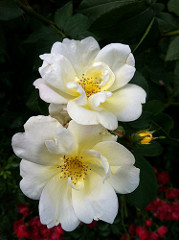

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

**keras.preprocessing사용**

dataset 만들기

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2, # 검증에 20%사용
subset="training",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

# 총 3670개의 파일, 5개의 클래스
# 2936개(80%)를 훈련에 사용

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
data_dir,
validation_split=0.2,
subset="validation",
seed=123,
image_size=(img_height, img_width),
batch_size=batch_size)

# 734개(20%)를 검증에 사용

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

# 클래스 이름 확인

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


데이터 시각화

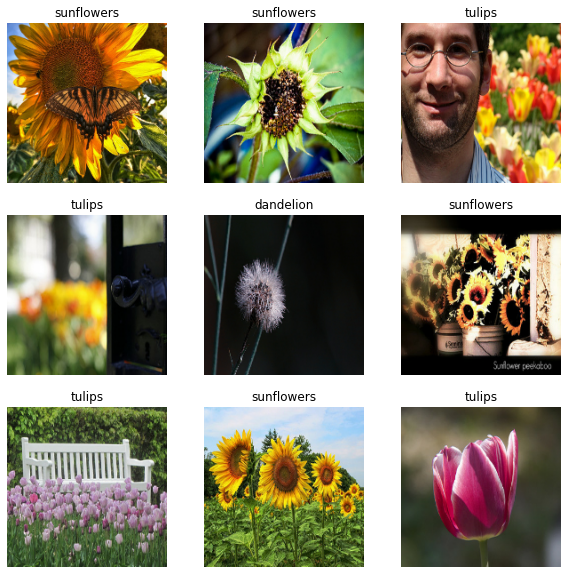

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
    # 180x180x3[rgb] 그림이 32개
    # 32개 그림의 레이블

(32, 180, 180, 3)
(32,)


데이터 표준화

In [16]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

# rescaling사용, 표준화

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [18]:
print(np.min(first_image), np.max(first_image))

0.0 0.99638706


In [20]:
# 이번엔 (-1,1)로 리스케일링 해보자

from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

-1.0 1.0


성능중시 dataset구성

In [21]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

모델 training

In [22]:
num_classes = 5

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [24]:
model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=10
)

# 10에폭 돌리니까 오버피팅된 것 같음..

Epoch 1/10
92/92 [==============================] - 62s 671ms/step - loss: 1.3273 - accuracy: 0.4176 - val_loss: 1.1222 - val_accuracy: 0.5191
Epoch 2/10
92/92 [==============================] - 51s 550ms/step - loss: 1.0256 - accuracy: 0.5896 - val_loss: 0.9727 - val_accuracy: 0.6240
Epoch 3/10
92/92 [==============================] - 49s 538ms/step - loss: 0.8546 - accuracy: 0.6781 - val_loss: 0.9310 - val_accuracy: 0.6376
Epoch 4/10
92/92 [==============================] - 52s 570ms/step - loss: 0.6820 - accuracy: 0.7446 - val_loss: 1.0433 - val_accuracy: 0.6267
Epoch 5/10
92/92 [==============================] - 54s 589ms/step - loss: 0.5182 - accuracy: 0.8161 - val_loss: 1.3863 - val_accuracy: 0.5722
Epoch 6/10
92/92 [==============================] - 49s 530ms/step - loss: 0.4122 - accuracy: 0.8525 - val_loss: 1.2101 - val_accuracy: 0.6253
Epoch 7/10
92/92 [==============================] - 49s 534ms/step - loss: 0.3293 - accuracy: 0.8862 - val_loss: 1.4002 - val_accuracy: 0.6213

tf.data로 finetuning

In [25]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [26]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\kbs77\\.keras\\datasets\\flower_photos\\tulips\\14025589299_eac64c51af_m.jpg'
b'C:\\Users\\kbs77\\.keras\\datasets\\flower_photos\\roses\\5835539224_75967fc400_m.jpg'
b'C:\\Users\\kbs77\\.keras\\datasets\\flower_photos\\roses\\15674450867_0ced942941_n.jpg'
b'C:\\Users\\kbs77\\.keras\\datasets\\flower_photos\\sunflowers\\5067864967_19928ca94c_m.jpg'
b'C:\\Users\\kbs77\\.keras\\datasets\\flower_photos\\roses\\15222804561_0fde5eb4ae_n.jpg'


In [27]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [28]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

# 훈련 / 검증 분할

In [30]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [31]:
def get_label(file_path): # path 
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [32]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [33]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [34]:
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [35]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


성능올라가는 데이터셋 구성

In [36]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

In [37]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

시각화

In [38]:
image_batch, label_batch = next(iter(train_ds))

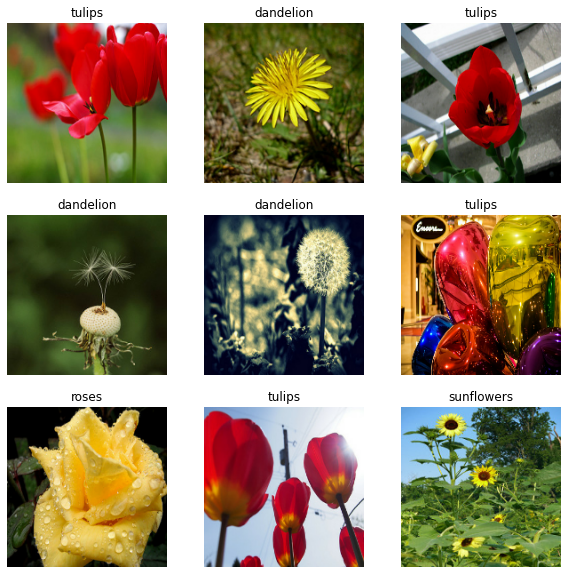

In [39]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1) # i + 1 : 그냥 i 면 0번째 레이블이라 에러남
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [41]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

ValueError: num must be 1 <= num <= 9, not 0

<Figure size 720x720 with 0 Axes>

모델 훈련

In [40]:
model.fit(
train_ds,
validation_data=val_ds,
epochs=3
)

Epoch 1/3
92/92 [==============================] - 53s 576ms/step - loss: 0.3579 - accuracy: 0.9040 - val_loss: 0.3184 - val_accuracy: 0.9074
Epoch 2/3
92/92 [==============================] - 50s 545ms/step - loss: 0.1262 - accuracy: 0.9649 - val_loss: 0.3183 - val_accuracy: 0.9087
Epoch 3/3
92/92 [==============================] - 50s 545ms/step - loss: 0.0473 - accuracy: 0.9884 - val_loss: 0.3208 - val_accuracy: 0.9237


TF dataset 이용

In [42]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
'tf_flowers',
split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
with_info=True,
as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling tf_flowers-train.tfrecord...:   0%|          | 0/3670 [00:00<?, ? examples/s]

Dataset tf_flowers downloaded and prepared to C:\Users\kbs77\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [43]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


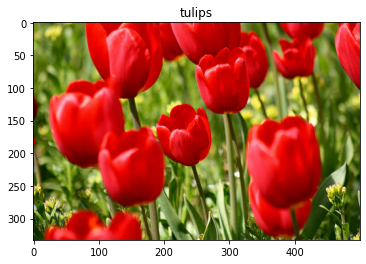

In [44]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [45]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)